# CONV1-D and LSTM Model.

# NOTE:

### There are two ways to train a model

* One is sequntial way and the second one is a kind of, I call it tensor way.  
* I don't know the proper detail of 2nd method but it works perfectly. 
* I guess it's a asynchoronous way.
##### .........

* One thing to Note is that in RNN, the input_shape of layer is :
   * (total_no_of_windows , total_no_of_features)

* The input_shape which we pass at "model.fit()" time is: (total_no_audio_samples, total_no_of_windows , total_no_of_features)


#### ONE MORE THING TO NOTE:

* total_no_of_windows == steps or timesteps
* total_no_of_features == vector_size or input_dims

#### MODEL 1:

(4909, 108, 13)
(4909, 108, 13)
(1228, 108, 13)
(2046, 108, 13)
Building model...
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, None, 13)]        0         
_________________________________________________________________
convolution_1 (Conv1D)       (None, None, 60)          2400      
_________________________________________________________________
batch_normalization_6 (Batch (None, None, 60)          240       
_________________________________________________________________
activation_6 (Activation)    (None, None, 60)          0         
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, None, 60)          0         
_________________________________________________________________
dropout_10 (Dropout)         (None, None, 60)          0         
___________________________________________

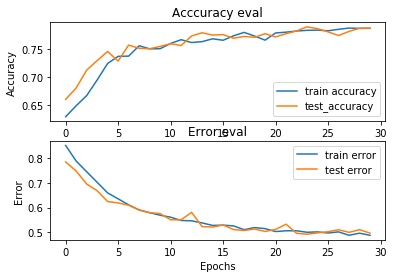

2046/2046 [==============================] - 0s 172us/sample - loss: 0.5094 - accuracy: 0.7796
Accuracy on test set is 0.7795698642730713
Target: 0, Predicted label: [0]


In [16]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, TimeDistributed, LSTM, Dropout, Activation
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Conv2D, BatchNormalization, Lambda
from tensorflow.keras.layers import ELU
from tensorflow.keras import regularizers

DATASET_PATH = "sick_sound.json"

def load_data(dataset_path):
    with open(dataset_path, "r") as fp:
        data = json.load(fp)
        
        
    # converting lists into numpy arrays
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    
    return X, y

def plot_history(history):
    
    fig, axis = plt.subplots(2)
    
    # create accuracy subplot
    axis[0].plot(history.history["accuracy"], label = "train accuracy" )
    axis[0].plot(history.history["val_accuracy"], label = "test_accuracy" )
    axis[0].set_ylabel("Accuracy")
    axis[0].set_xlabel("Epochs")
    axis[0].legend(loc = "lower right")
    axis[0].set_title("Acccuracy eval")
    
    
    # create error subplot
    axis[1].plot(history.history["loss"], label = "train error" )
    axis[1].plot(history.history["val_loss"], label = "test error" )
    axis[1].set_ylabel("Error")
    axis[1].set_xlabel("Epochs")
    axis[1].legend(loc = "upper right")
    axis[1].set_title("Error eval")
    
    plt.show()

def prepare_datasets(test_size, validation_size):
    
    # load dataset
    X, y = load_data(DATASET_PATH)
    
    # create train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)
    
    # create train/validataion split
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size= validation_size)
    
    print(X_train.shape)
    
    # so in X_train we have 3d array --> (sample_size, mfcc_vector, mfcc_coefficient)
    # so we have to introduce another dimension in it. and make it 4d array. 
#     X_train = X_train[... , np.newaxis]
#     # ... 3dots mean keep the rest of the shape same.
#     X_validation = X_validation[..., np.newaxis]
#     X_test = X_test[..., np.newaxis]
    
    print(X_train.shape)
    print(X_validation.shape)
    print(X_test.shape)
    
    
    return X_train, X_validation, X_test, y_train, y_validation, y_test
    

def build_model(input_shape):
    
    N_LAYERS = 3
    
    print('Building model...')
    
    # first of all we will specify input shape to our "1d_conv" model which is (total_no_of_windows, no_of_features)
    layer = input_shape
    
    ### 3 1D-Convolution Layers
    for i in range(N_LAYERS):
        # give name to the layers
        # overhere we will not pass input_shape.
        layer = Conv1D(
                filters=60,
                kernel_size=3,
                kernel_regularizer=regularizers.l2(0.001),  # Tried 0.001
                name='convolution_' + str(i + 1)
            )(layer)
        layer = BatchNormalization(momentum=0.9)(layer)
        layer = Activation('relu')(layer)
        layer = MaxPooling1D(2)(layer)
        layer = Dropout(0.4)(layer)
    
    ## LSTM Layer
    layer = LSTM(60, return_sequences=False)(layer)
    layer = Dropout(0.4)(layer)
    
    ## Dense Layer
    layer = Dense(120, kernel_regularizer=regularizers.l2(0.001), name='dense1')(layer)
    layer = Dropout(0.4)(layer)
    
    ## Softmax Output
    layer = Dense(2)(layer)
    layer = Activation('softmax', name='output_realtime')(layer)
    model_output = layer
    
    # at the end we have to pass this all the stack of layers into a Model() function with input_shape and output_layer.
    model = Model(input_shape, model_output)
    
    return model


def predict(model, X, y):
    
    # add a new dimension to input data for sample.   model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y, predicted_index))



if __name__ == "__main__":

    # Create train, validation and test set
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.20)
    
    # if u done want to specify total_no_windows, u can use None. but u have to specify no_features.
    input_shape = (None, X_train.shape[2])
    # if u use Non_sequential approach i.e. first in the layers u passed input layer in which u specified  
    # input_shape then u stacked layers of conv-1d over it. for this approach u have to pass the inputs in the form of tensor.
    # so for passing input_shape in the form of tensor we use a method name "Input()" . In this method
    # we pass our input shape, so that model can receive inputs as a tensor.
    model_input = Input(input_shape, name='input')
    
    # build the CNN network architecture
    
    # in the build_model method we will pass inputs in the form of tensors.   
    model = build_model(model_input)
    
    # compile the network
    optimizer = keras.optimizers.Adam(learning_rate = 0.001)
    model.compile(optimizer = optimizer,
                  loss = "sparse_categorical_crossentropy",
                  metrics = ["accuracy"]
                 )
    
    model.summary()
    
    # train the CNN
    history = model.fit(X_train,
              y_train,
              validation_data = (X_validation, y_validation),
              batch_size = 32,
              epochs = 30
             )
    
    # plot accuracy/error for training and validation
    plot_history(history)
    
    # evaluate the CNN on the test set
    test_error, test_accuracy = model.evaluate(X_test, y_test, verbose = 1)
    print("Accuracy on test set is {}".format(test_accuracy))
    
    # pick a sample to predict from the test set
    X_to_predict = X_test[50]
    y_to_predict = y_test[50]

    # predict sample
    predict(model, X_to_predict, y_to_predict)
    
    


In [31]:
# For checkinf dimensions of your data

In [3]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt

dataset_path = "data.json"

with open(dataset_path, "r") as fp:
        data = json.load(fp)
        
        
# converting lists into numpy arrays
X = np.array(data["mfcc"])
y = np.array(data["labels"])

In [5]:
X.shape[2]

13

# Experimental model 2:

(4909, 108, 13)
(4909, 108, 13)
(1228, 108, 13)
(2046, 108, 13)
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
convolution_1 (Conv1D)       (None, 106, 60)           2400      
_________________________________________________________________
convolution_2 (Conv1D)       (None, 104, 60)           10860     
_________________________________________________________________
convolution_3 (Conv1D)       (None, 102, 60)           10860     
_________________________________________________________________
batch_normalization_10 (Batc (None, 102, 60)           240       
_________________________________________________________________
activation_10 (Activation)   (None, 102, 60)           0         
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 51, 60)            0         
________________________________________________________

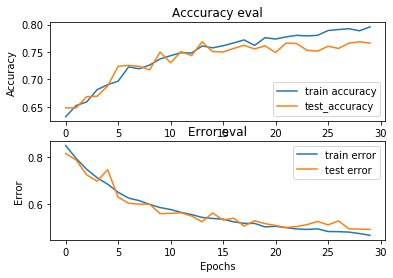

2046/2046 [==============================] - 1s 342us/sample - loss: 0.4710 - accuracy: 0.7952
Accuracy on test set is 0.7952101826667786
Target: 0, Predicted label: [0]


In [28]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, TimeDistributed, LSTM, Dropout, Activation
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Conv2D, BatchNormalization, Lambda
from tensorflow.keras.layers import ELU
from tensorflow.keras import regularizers

DATASET_PATH = "sick_sound.json"

def load_data(dataset_path):
    with open(dataset_path, "r") as fp:
        data = json.load(fp)
        
        
    # converting lists into numpy arrays
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    
    return X, y

def plot_history(history):
    
    fig, axis = plt.subplots(2)
    
    # create accuracy subplot
    axis[0].plot(history.history["accuracy"], label = "train accuracy" )
    axis[0].plot(history.history["val_accuracy"], label = "test_accuracy" )
    axis[0].set_ylabel("Accuracy")
    axis[0].set_xlabel("Epochs")
    axis[0].legend(loc = "lower right")
    axis[0].set_title("Acccuracy eval")
    
    
    # create error subplot
    axis[1].plot(history.history["loss"], label = "train error" )
    axis[1].plot(history.history["val_loss"], label = "test error" )
    axis[1].set_ylabel("Error")
    axis[1].set_xlabel("Epochs")
    axis[1].legend(loc = "upper right")
    axis[1].set_title("Error eval")
    
    plt.show()

def prepare_datasets(test_size, validation_size):
    
    # load dataset
    X, y = load_data(DATASET_PATH)
    
    # create train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)
    
    # create train/validataion split
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size= validation_size)
    
    print(X_train.shape)
    
    # so in X_train we have 3d array --> (sample_size, mfcc_vector, mfcc_coefficient)
    # so we have to introduce another dimension in it. and make it 4d array. 
#     X_train = X_train[... , np.newaxis]
#     # ... 3dots mean keep the rest of the shape same.
#     X_validation = X_validation[..., np.newaxis]
#     X_test = X_test[..., np.newaxis]
    
    print(X_train.shape)
    print(X_validation.shape)
    print(X_test.shape)
    
    
    return X_train, X_validation, X_test, y_train, y_validation, y_test
    

def build_model(input_shape):
    
#     N_LAYERS = 3
    
#     print('Building model...')
#     layer = input_shape
    
#     ### 3 1D Convolution Layers
#     for i in range(N_LAYERS):
#         # give name to the layers
#         layer = Conv1D(
#                 filters=60,
#                 kernel_size=3,
#                 kernel_regularizer=regularizers.l2(0.001),  # Tried 0.001
#                 name='convolution_' + str(i + 1)
#             )(layer)
#         layer = BatchNormalization(momentum=0.9)(layer)
#         layer = Activation('relu')(layer)
#         layer = MaxPooling1D(2)(layer)
#         layer = Dropout(0.4)(layer)
    
#     ## LSTM Layer
#     layer = LSTM(60, return_sequences=False)(layer)
#     layer = Dropout(0.4)(layer)
    
#     ## Dense Layer
#     layer = Dense(120, kernel_regularizer=regularizers.l2(0.001), name='dense1')(layer)
#     layer = Dropout(0.4)(layer)
    
#     ## Softmax Output
#     layer = Dense(2)(layer)
#     layer = Activation('softmax', name='output_realtime')(layer)
#     model_output = layer
#     model = Model(input_shape, model_output)
    
#     return model
    
    
   # create model
    model = keras.Sequential()
    
    N_LAYERS = 3
    for i in range(N_LAYERS):
        # 1d-conv layers
        model.add(keras.layers.Conv1D(
                    filters=60,
                    kernel_size=3,
                    input_shape = input_shape,
                    kernel_regularizer=regularizers.l2(0.001),  # Tried 0.001
                    name='convolution_' + str(i + 1)
                    ))
        
        
    model.add(keras.layers.BatchNormalization(momentum=0.9))
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.MaxPooling1D(2))
    model.add(keras.layers.Dropout(0.4))

    # LSTM Layer
    model.add(keras.layers.LSTM(60, return_sequences=False))
    model.add(keras.layers.Dropout(0.4))
    
              
    ## Dense Layer
    model.add(keras.layers.Dense(120, kernel_regularizer=regularizers.l2(0.001), name='dense1'))
    model.add(keras.layers.Dropout(0.4))
    
    ## Softmax Output
    model.add(keras.layers.Dense(2))
    model.add(keras.layers.Activation('softmax', name='output_realtime'))
#     model_output = model
#     model_ss = Model(input_shape, model_output)
              
    return model
              

    

def predict(model, X, y):

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y, predicted_index))



if __name__ == "__main__":

    # Create train, validation and test set
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.20)
    
    input_shape = (X_train.shape[1], X_train.shape[2])
#     model_input = Input(input_shape, name='input')
    
    # build the CNN network architecture
#     model = build_model(model_input)
    model = build_model(input_shape)
    
    # compile the network
    optimizer = keras.optimizers.Adam(learning_rate = 0.001)
    model.compile(optimizer = optimizer,
                  loss = "sparse_categorical_crossentropy",
                  metrics = ["accuracy"]
                 )
    
    model.summary()
    
    # train the CNN
    history = model.fit(X_train,
              y_train,
              validation_data = (X_validation, y_validation),
              batch_size = 32,
              epochs = 30
             )
    
    # plot accuracy/error for training and validation
    plot_history(history)
    
    # evaluate the CNN on the test set
    test_error, test_accuracy = model.evaluate(X_test, y_test, verbose = 1)
    print("Accuracy on test set is {}".format(test_accuracy))
    
    # pick a sample to predict from the test set
    X_to_predict = X_test[50]
    y_to_predict = y_test[50]

    # predict sample
    predict(model, X_to_predict, y_to_predict)
    
    


# PLotting confusion matrix

In [32]:
from sklearn.metrics import confusion_matrix

yhat_probs = model.predict(X_test, verbose=0)
tt = np.argmax(yhat_probs, axis = 1)

cm=confusion_matrix(y_test, tt)
print(cm)

[[1176  153]
 [ 266  451]]


In [34]:
from sklearn.metrics import classification_report

y_true = np.argmax(y_valid, axis = 1)
y_pred = model.predict(X_valid)
y_pred = np.argmax(y_pred, axis=1)
labels = [0,1,2,3,4,5,6,7]
target_names = dict_genres.keys()

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))

# MODEL 3 With sequential layers.

* Overhere I have used sequential approach.

In [ ]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, TimeDistributed, LSTM, Dropout, Activation
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Conv2D, BatchNormalization, Lambda
from tensorflow.keras.layers import ELU
from tensorflow.keras import regularizers

DATASET_PATH = "sick_sound.json"

def load_data(dataset_path):
    with open(dataset_path, "r") as fp:
        data = json.load(fp)
        
        
    # converting lists into numpy arrays
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    
    return X, y

def plot_history(history):
    
    fig, axis = plt.subplots(2)
    
    # create accuracy subplot
    axis[0].plot(history.history["accuracy"], label = "train accuracy" )
    axis[0].plot(history.history["val_accuracy"], label = "test_accuracy" )
    axis[0].set_ylabel("Accuracy")
    axis[0].set_xlabel("Epochs")
    axis[0].legend(loc = "lower right")
    axis[0].set_title("Acccuracy eval")
    
    
    # create error subplot
    axis[1].plot(history.history["loss"], label = "train error" )
    axis[1].plot(history.history["val_loss"], label = "test error" )
    axis[1].set_ylabel("Error")
    axis[1].set_xlabel("Epochs")
    axis[1].legend(loc = "upper right")
    axis[1].set_title("Error eval")
    
    plt.show()

def prepare_datasets(test_size, validation_size):
    
    # load dataset
    X, y = load_data(DATASET_PATH)
    
    # create train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)
    
    # create train/validataion split
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size= validation_size)
    
    
    print(X_train.shape)
    print(X_validation.shape)
    print(X_test.shape)
    
    
    return X_train, X_validation, X_test, y_train, y_validation, y_test
    

def build_model(input_shape):
    
   #    create a sequential model
    model = keras.Sequential()
    
    # remember when u use a sequential approach u pass input_shape in the layer, not outside the layer. 
    
    N_LAYERS = 3
    for i in range(N_LAYERS):
        # 1d-conv layers
        model.add(keras.layers.Conv1D(
                    filters=60,
                    kernel_size=3,
                    input_shape = input_shape,
                    kernel_regularizer=regularizers.l2(0.001),  # Tried 0.001
                    name='convolution_' + str(i + 1)
                    ))
        
        
    model.add(keras.layers.BatchNormalization(momentum=0.9))
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.MaxPooling1D(2))
    model.add(keras.layers.Dropout(0.4))

    # LSTM Layer
    model.add(keras.layers.LSTM(60, return_sequences=False))
    model.add(keras.layers.Dropout(0.4))
    
              
    ## Dense Layer
    model.add(keras.layers.Dense(120, kernel_regularizer=regularizers.l2(0.001), name='dense1'))
    model.add(keras.layers.Dropout(0.4))
    
    ## Softmax Output
    model.add(keras.layers.Dense(2))
    model.add(keras.layers.Activation('softmax', name='output_realtime'))

    return model
              
    
def predict(model, X, y):

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y, predicted_index))



if __name__ == "__main__":

    # Create train, validation and test set
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.20)
    
    # we pass input_shape as (total_no_windows , total_no_features)  --> total_no_features are 13 here.
    input_shape = (X_train.shape[1], X_train.shape[2])
    
    # when u use sequential approach u dont need to pass inputs in the form of tensors, u can directy pass input_shape
    # as a numpy array. no need to convert it into tensors. 
   
    model = build_model(input_shape)
    
    # compile the network
    optimizer = keras.optimizers.Adam(learning_rate = 0.001)
    model.compile(optimizer = optimizer,
                  loss = "sparse_categorical_crossentropy",
                  metrics = ["accuracy"]
                 )
    
    model.summary()
    
    # train the CNN
    history = model.fit(X_train,
              y_train,
              validation_data = (X_validation, y_validation),
              batch_size = 32,
              epochs = 30
             )
    
    # plot accuracy/error for training and validation
    plot_history(history)
    
    # evaluate the CNN on the test set
    test_error, test_accuracy = model.evaluate(X_test, y_test, verbose = 1)
    print("Accuracy on test set is {}".format(test_accuracy))
    
    # pick a sample to predict from the test set
    X_to_predict = X_test[50]
    y_to_predict = y_test[50]

    # predict sample
    predict(model, X_to_predict, y_to_predict)
    